# Polygon workaround

- **Idea**: Building a shape vector for each contour point

- **Construction step**:
    1. Pre-processing
        + Load image
        + Load the list of color

    2. Extracting contour
        + Extract contour based on DBz map
        + Reduce the number of vertices using *Douglas-Peucker* algorithm
    
    3. Building shape vector map
        + Build a shape vector for each vertex in the boundary

## I. Load data

In [16]:
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

from utils import *
from contours_extraction import *
from tracking import *

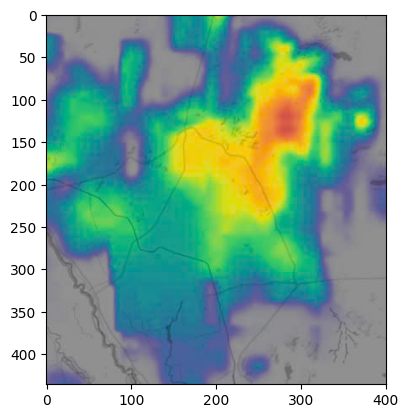

In [17]:
img_path = 'data/image_old/weather_7.jpg'
src_img = plt.imread(img_path)

plt.imshow(src_img)
plt.show()

In [18]:
with open('data/legend/color_dbz.json') as f:
    list_color = json.load(f)

sorted_color = sorted({tuple(color[1]): color[0] for color in list_color}.items(), key=lambda item: item[1])
sorted_color[:3]

[((130, 130, 130), 0), ((123, 121, 132), 3), ((95, 85, 141), 8)]

## 2. Extract contours

Number of polygons = 6


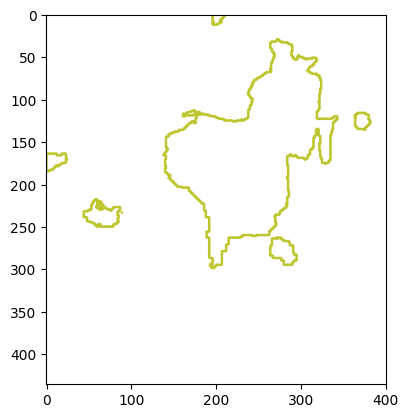

In [19]:
contours_img, contours, colors  = extract_contour_by_dbz(src_img, thresholds=[30], sorted_color=sorted_color)
contours = sorted([polygon for polygon in contours[0] if cv2.contourArea(polygon) >= 15], key=lambda x: cv2.contourArea(x), reverse=True)
print(f"Number of polygons = {len(contours)}")

plt.imshow(contours_img)
plt.show()

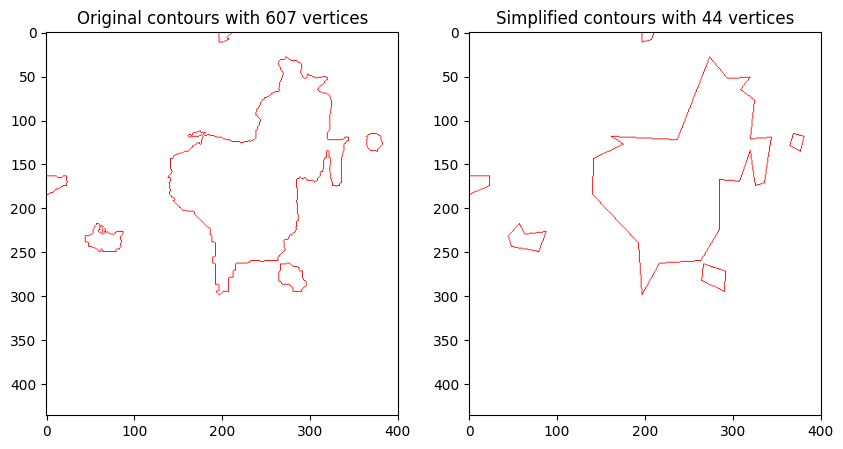

In [20]:
polygons = process_contours(contours)
simplified_contours = polygons_to_contours(polygons)

original_vertices = sum([contour.shape[0] for contour in contours])
simplified_vertices = sum([contour.shape[0] for contour in simplified_contours])

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
# Left: simplified contour
blank_img = np.ones(shape=src_img.shape, dtype=np.uint8) * 255
cv2.drawContours(blank_img, contours, contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.title(f"Original contours with {original_vertices} vertices")
plt.imshow(blank_img)

# Right: contour
plt.subplot(1, 2, 2)
blank_img = np.ones(shape=src_img.shape, dtype=np.uint8) * 255
cv2.drawContours(blank_img, simplified_contours  , contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.title(f"Simplified contours with {simplified_vertices} vertices")
plt.imshow(blank_img)

plt.show()

## 3. Build vector map for each point in contours

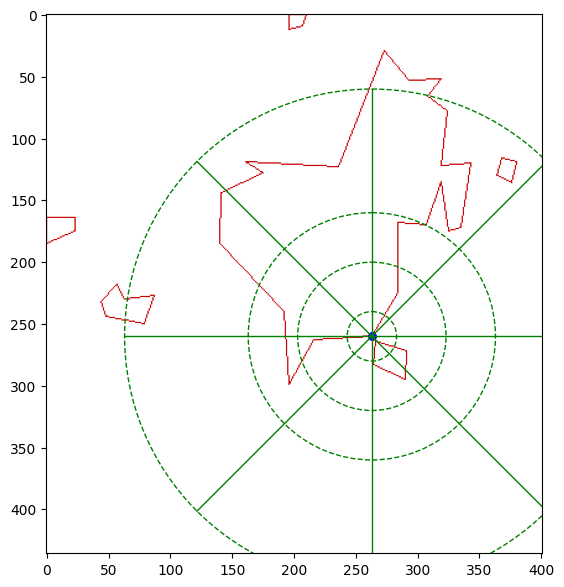

In [21]:
def plot_shape_vector(contours, point_A, radii, num_sectors):
    plt.figure(figsize=(7, 7))
    fig = plt.gcf()
    ax = fig.gca()

    blank_img = np.ones_like(src_img, dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    cv2.drawContours(blank_img, contours, -1, color=(200,0,0), thickness=1)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    plt.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    plt.imshow(blank_img)
    plt.show()

radii = [20, 60, 100, 200]
num_sectors = 8

point = simplified_contours[0][9][0]
features_vector = construct_shape_vector(polygons, point, radii=radii, num_sectors=num_sectors)

plot_shape_vector(simplified_contours, point, radii, num_sectors)

## 3. Extract a global set of keypoints of weather image

In [ ]:
points = [point for contour in simplified_contours for point in contour.squeeze(1)]

point_features = []

for point in points:
    try:
        point_features.append((
            ShapeVector(point, construct_shape_vector(polygons, point, radii=radii, num_sectors=num_sectors))
        ))
    except:
        pass

len(points), len(point_features)

(44, 44)

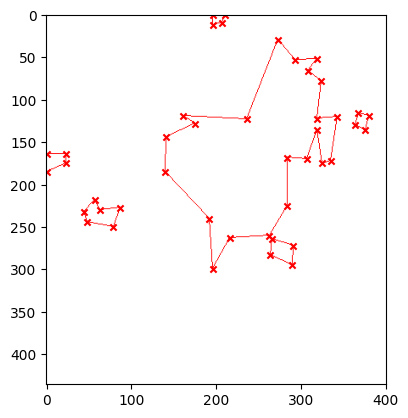

In [23]:
blank_img = np.ones_like(src_img, np.int16) * 255
cv2.drawContours(blank_img, simplified_contours, contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.imshow(blank_img)

for point in points:
    plt.scatter(point[0], point[1], s=20, c='red', marker='x')

plt.show()

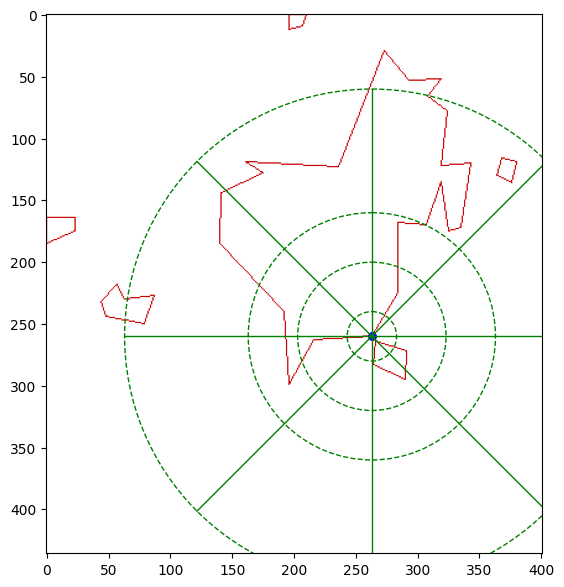

In [24]:
plot_shape_vector(simplified_contours, points[9], radii=radii, num_sectors=num_sectors)
plt.show()